In [1]:
# Daniel Armani, PhD : April, 2025

import sys
print(f"Python version: {sys.version}")

import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

import torch
print(f"PyTorch version: {torch.__version__}")

import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
cuda


In [2]:
# Generate Some fake data:

np.random.seed(2025)
torch.manual_seed(2025)

n_samples = 10000
n_inputs = 5
n_outputs = 3

# Introduce correlations among X0, X1, X2 & X3 but no correlation with X4!
correlation_matrix = np.eye(n_inputs)
correlation_matrix[0, 1] = correlation_matrix[1, 0] = 0.6
correlation_matrix[2, 3] = correlation_matrix[3, 2] = -0.2

correlation_matrix

array([[ 1. ,  0.6,  0. ,  0. ,  0. ],
       [ 0.6,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. , -0.2,  0. ],
       [ 0. ,  0. , -0.2,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [3]:
# Cholesky decomposition for correlated random variables
cov_matrix = np.linalg.cholesky(correlation_matrix)
X = np.dot(np.random.randn(n_samples, n_inputs), cov_matrix)

X.shape

(10000, 5)

In [4]:
# Linear relationship:
raw_y1 = 1.5*X[:, 0] - 0.5*X[:, 1] + 0.1*X[:, 2] + np.random.normal(0, 0.5, size=(n_samples,))

# With interactions:
raw_y2 = 0.7*X[:, 1] + 0.3*X[:, 2] + 0.5*X[:, 0]*X[:, 3] + np.random.uniform(-0.5, 0.5, size=(n_samples,))

# Complex non-linear interactions:
epsilon = 1e-10
raw_y3 = (
    np.sin(2*X[:, 0]) * np.cos(X[:, 1])  # Trigonometric interaction
    + np.tanh(X[:, 2] + X[:, 3])  # Non-linear transformation of sum
    + np.exp(X[:, 4]/5) / (1 + np.exp(X[:, 4]/5))  # Sigmoid-like function
    + 0.3 * np.log(np.abs(X[:, 0]*X[:, 2]) + epsilon)  # Log of interaction
    - 0.5 * (X[:, 1]**2 * X[:, 3])  # Higher-order interaction
    + 0.2 * np.maximum(0, X[:, 2])  # ReLU-like function
    + np.random.normal(0, 0.3, size=(n_samples,))  # Noise
)

# Get thresholds for exactly 50% split binary outcome
threshold_y1 = np.median(raw_y1)
threshold_y2 = np.median(raw_y2)
threshold_y3 = np.median(raw_y3)

y1 = (raw_y1 > threshold_y1).astype(int)
y2 = (raw_y2 > threshold_y2).astype(int)
y3 = (raw_y3 > threshold_y3).astype(int)

Y = np.column_stack([y1, y2, y3])

Y.shape

(10000, 3)

In [5]:
# Split and prepare data:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2025)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
Y_train_tensor = torch.FloatTensor(Y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
Y_test_tensor = torch.FloatTensor(Y_test)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 5), (2000, 5), (8000, 3), (2000, 3))

In [6]:
def num_param(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
# 1. Multivariate Logistic Regression:

lr_models = []
lr_predictions = np.zeros((X_test.shape[0], n_outputs))

for i in range(n_outputs):
    lr = LogisticRegression(C=1e6, random_state=2, max_iter=10000, tol=1e-8)
    lr.fit(X_train_scaled, Y_train[:, i])
    lr_models.append(lr)
    print(f"\n Coefficients: {lr.coef_[0]}, Intercept: {lr.intercept_[0]:.3f}")

    lr_predictions[:, i] = lr.predict(X_test_scaled)

    print(f"Output y{i+1} accuracy: {lr.score(X_test_scaled, Y_test[:, i])}")


 Coefficients: [ 6.17462127 -1.41605674  0.38145854 -0.03377563  0.0152006 ], Intercept: -0.019
Output y1 accuracy: 0.9015

 Coefficients: [-0.23303093  1.75072474  0.99059278  0.07096124  0.01632559], Intercept: -0.011
Output y2 accuracy: 0.781

 Coefficients: [ 0.3401595  -0.08341299  1.09054417  0.36270869  0.07834484], Intercept: -0.006
Output y3 accuracy: 0.709


In [8]:
# 2. Simple Neural Network:

class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

simple_nn = SimpleNN(n_inputs, n_outputs)

print(f"Number of parameters: {num_param(simple_nn)}")
simple_nn

Number of parameters: 18


SimpleNN(
  (linear): Linear(in_features=5, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
# 3. Neural Network with one linear hidden layer with no activation function:

class LinearHiddenNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearHiddenNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

linear_hidden = LinearHiddenNN(n_inputs, 3, n_outputs)
print(f"Number of parameters: {num_param(linear_hidden)}")
linear_hidden

Number of parameters: 30


LinearHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
    (2): Sigmoid()
  )
)

In [10]:
# 4. Neural Network with a hidden layer with ReLU activation function:

class ReluHiddenNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReluHiddenNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

MAX_NEURONS = 30
MAX_NEURONS

# Create an array of grayscale values from light to dark
grays = np.linspace(0.7, 0.2,MAX_NEURONS)
colors = [(g, g, g) for g in grays]

In [11]:
# Create instances with different hidden sizes

relu_hidden = []
for hidden_size in range(1, MAX_NEURONS+1):
    instance = ReluHiddenNN(n_inputs, hidden_size, n_outputs)
    relu_hidden.append(instance)
    print(f"\n Linear Hidden with {hidden_size} Neurons and {num_param(instance)} parameters:")
    print(instance)


 Linear Hidden with 1 Neurons and 12 parameters:
ReluHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

 Linear Hidden with 2 Neurons and 21 parameters:
ReluHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

 Linear Hidden with 3 Neurons and 30 parameters:
ReluHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

 Linear Hidden with 4 Neurons and 39 parameters:
ReluHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

 Linear Hidden with 5 N

In [12]:
# 5. The Neural Network with two hidden layers (ReLU):

class TwoHiddenNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(TwoHiddenNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

two_hidden = TwoHiddenNN(n_inputs, 8, 8, n_outputs) # 16 Neurons in the hidden layers
print(f"Number of parameters: {num_param(two_hidden)}")
two_hidden

Number of parameters: 147


TwoHiddenNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
    (5): Sigmoid()
  )
)

In [13]:
# Function to train the Neural Network models:

def train_model(model, X_train, Y_train, max_epochs=9000, lr=0.1, tol=1e-20):
    model = model.to(device)

    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.9)

    model.train()

    losses = []
    prev_loss = float('inf')

    start_time = time.time()

    for epoch in range(max_epochs):
        y_pred = model(X_train)
        loss = criterion(y_pred, Y_train)
        losses.append(loss.item())
        current_loss = loss.item()

        if abs(prev_loss - current_loss) < tol:
            print(f"Converged at epoch {epoch} with loss {current_loss:.8f}")
            break

        if (epoch) % 100 == 0:
            print(f"Epoch {epoch}/{max_epochs}, Loss: {loss.item():.4f}")

        prev_loss = current_loss

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        scheduler.step()

    if epoch == max_epochs - 1:
        print(f"Reached max epochs {max_epochs} with loss {current_loss:.8f}")

    print(f"Training duration = {time.time() - start_time} seconds")

    return losses

train_model

<function __main__.train_model(model, X_train, Y_train, max_epochs=9000, lr=0.1, tol=1e-20)>

In [14]:
# Training Models and Obtaining Losses:

print(f"\n Simple NN, training {num_param(simple_nn)} parameters: ")
simple_losses = train_model(simple_nn, X_train_tensor, Y_train_tensor)

print(f"\n One Linear Hidden NN, training {num_param(linear_hidden)} parameters: ")
linear_hidden_losses= train_model(linear_hidden, X_train_tensor, Y_train_tensor)

relu_hidden_losses = [[] for _ in range(len(relu_hidden))]
for i, instance in enumerate(relu_hidden):
  print(f"\n ReLU Hidden Layer with {i+1} Neurons, training {num_param(instance)} parameters: ")
  relu_hidden_losses[i] = train_model(instance, X_train_tensor, Y_train_tensor)

print(f"\n Two ReLU Hidden NN, training {num_param(two_hidden)} parameters: ")
two_hidden_losses = train_model(two_hidden, X_train_tensor, Y_train_tensor)


 Simple NN, training 18 parameters: 
Epoch 0/9000, Loss: 0.7577
Epoch 100/9000, Loss: 0.4302
Epoch 200/9000, Loss: 0.4274
Epoch 300/9000, Loss: 0.4268
Epoch 400/9000, Loss: 0.4266
Epoch 500/9000, Loss: 0.4265
Epoch 600/9000, Loss: 0.4265
Epoch 700/9000, Loss: 0.4265
Epoch 800/9000, Loss: 0.4264
Converged at epoch 844 with loss 0.42643547
Training duration = 2.2663040161132812 seconds

 One Linear Hidden NN, training 30 parameters: 
Epoch 0/9000, Loss: 0.7325
Epoch 100/9000, Loss: 0.4263
Converged at epoch 102 with loss 0.42630339
Training duration = 0.15150141716003418 seconds

 ReLU Hidden Layer with 1 Neurons, training 12 parameters: 
Epoch 0/9000, Loss: 0.7404
Epoch 100/9000, Loss: 0.5295
Epoch 200/9000, Loss: 0.5288
Epoch 300/9000, Loss: 0.5285
Epoch 400/9000, Loss: 0.5284
Epoch 500/9000, Loss: 0.5284
Epoch 600/9000, Loss: 0.5284
Epoch 700/9000, Loss: 0.5284
Converged at epoch 762 with loss 0.52835983
Training duration = 1.4312818050384521 seconds

 ReLU Hidden Layer with 2 Neuron

In [15]:
print(f"Simple No Hidden Layer: {simple_losses[-1]}")

print(f"One Linear Hidden Layer : {linear_hidden_losses[-1]}")

for i, instance in enumerate(relu_hidden):
  print(f"One Relu Hidden {i+1}: {relu_hidden_losses[i][-1]}")

print(f"Two ReLU Hidden Layers     : {two_hidden_losses[-1]}")

Simple No Hidden Layer: 0.4264354705810547
One Linear Hidden Layer : 0.4263033866882324
One Relu Hidden 1: 0.5283598303794861
One Relu Hidden 2: 0.44416260719299316
One Relu Hidden 3: 0.3891715407371521
One Relu Hidden 4: 0.3493776023387909
One Relu Hidden 5: 0.34609219431877136
One Relu Hidden 6: 0.3069169819355011
One Relu Hidden 7: 0.29744356870651245
One Relu Hidden 8: 0.3015672266483307
One Relu Hidden 9: 0.29425665736198425
One Relu Hidden 10: 0.27735647559165955
One Relu Hidden 11: 0.27386438846588135
One Relu Hidden 12: 0.27161115407943726
One Relu Hidden 13: 0.26274174451828003
One Relu Hidden 14: 0.260497510433197
One Relu Hidden 15: 0.2675537168979645
One Relu Hidden 16: 0.2635575830936432
One Relu Hidden 17: 0.257636159658432
One Relu Hidden 18: 0.2524692416191101
One Relu Hidden 19: 0.25178268551826477
One Relu Hidden 20: 0.24656985700130463
One Relu Hidden 21: 0.2500030994415283
One Relu Hidden 22: 0.24570304155349731
One Relu Hidden 23: 0.2534154951572418
One Relu Hidden

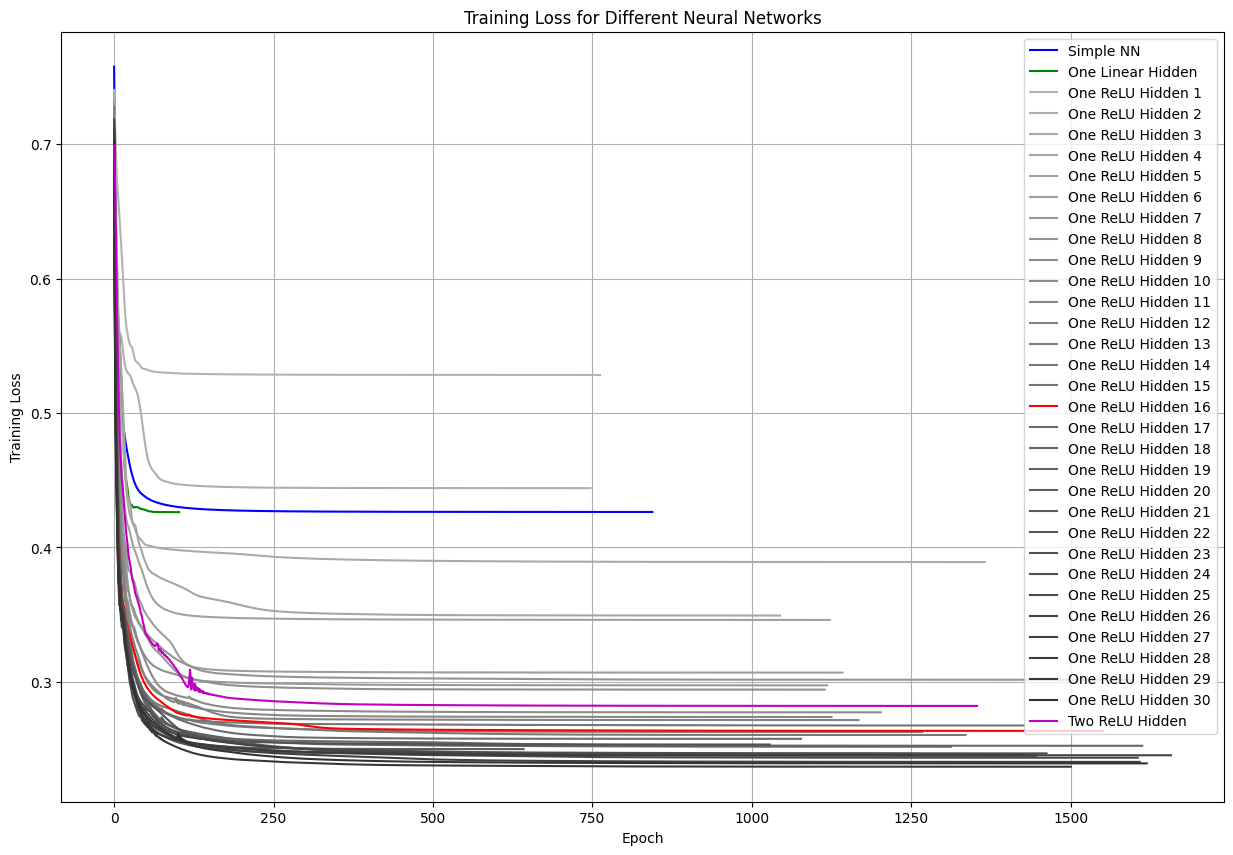

In [16]:
# Plots for the losses:

plt.figure(figsize=(15, 10))

plt.plot(simple_losses, label='Simple NN', color='b')
plt.plot(linear_hidden_losses, label='One Linear Hidden', color='g')

for i, instance in enumerate(relu_hidden):
  if i == 15: color = 'r'
  else: color = colors[i]
  plt.plot(relu_hidden_losses[i], label=f'One ReLU Hidden {i+1}', color=color)

plt.plot(two_hidden_losses, label='Two ReLU Hidden', color='m')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Neural Networks')

plt.legend()
plt.grid(True)
plt.show()

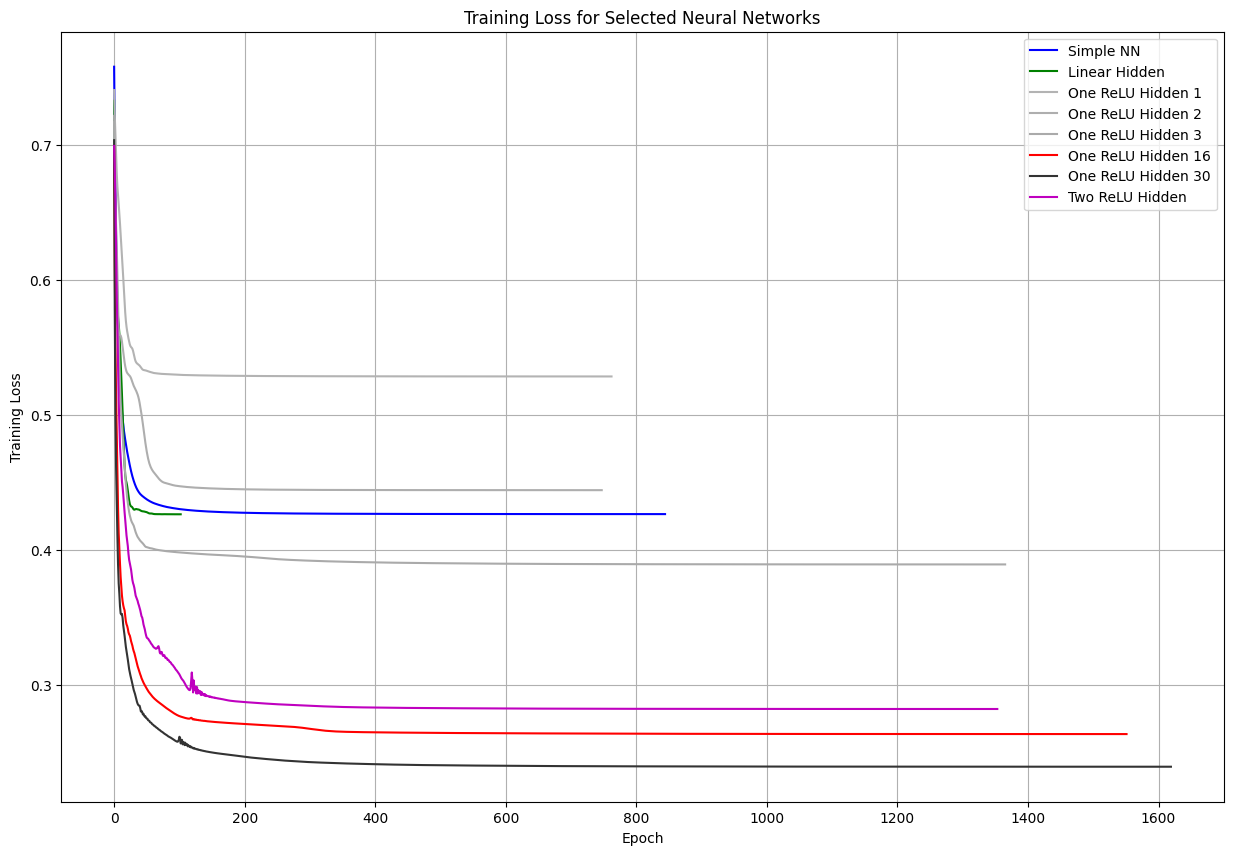

In [17]:
# Plots for the losses:

plt.figure(figsize=(15, 10))

plt.plot(simple_losses, label='Simple NN', color='b')
plt.plot(linear_hidden_losses, label='Linear Hidden', color='g')
plt.plot(relu_hidden_losses[0], label=f'One ReLU Hidden {1}', color=colors[0])
plt.plot(relu_hidden_losses[1], label=f'One ReLU Hidden {2}', color=colors[1])
plt.plot(relu_hidden_losses[2], label=f'One ReLU Hidden {3}', color=colors[2])
plt.plot(relu_hidden_losses[15], label=f'One ReLU Hidden {16}', color='r')
plt.plot(relu_hidden_losses[29], label=f'One ReLU Hidden {30}', color=colors[29])
plt.plot(two_hidden_losses, label='Two ReLU Hidden', color='m')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Selected Neural Networks')

plt.legend()
plt.grid(True)
plt.show()

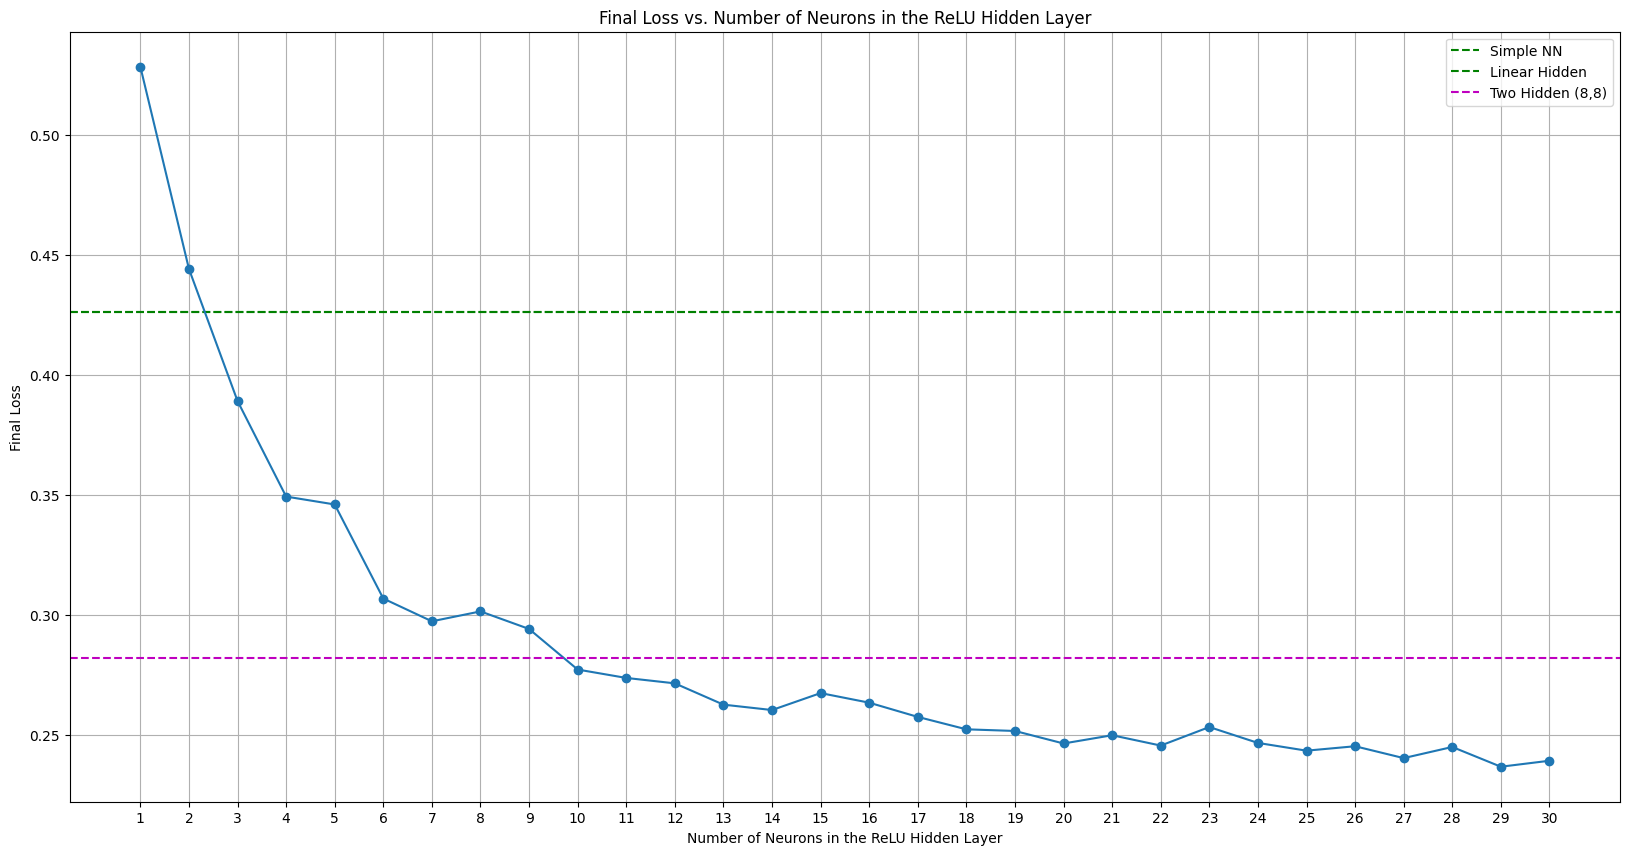

In [18]:
# Plot for final losses for the linear hidden layer

plt.figure(figsize=(20, 10))

plt.axhline(y=simple_losses[-1], color='g', linestyle='--', label='Simple NN')
plt.axhline(y=linear_hidden_losses[-1], color='g', linestyle='--', label='Linear Hidden')
plt.plot(range(1, MAX_NEURONS + 1), [relu_hidden_losses[i][-1] for i in range(MAX_NEURONS)], marker='o') #, color='k'
plt.axhline(y=two_hidden_losses[-1], color='m', linestyle='--', label='Two Hidden (8,8)')

plt.xticks(range(1, MAX_NEURONS + 1))
plt.xlabel('Number of Neurons in the ReLU Hidden Layer')
plt.ylabel('Final Loss')
plt.title('Final Loss vs. Number of Neurons in the ReLU Hidden Layer')

plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Function to Evaluate the Neural Network Models:

def evaluate_model(y_true, y_pred, message):
    accuracies = []
    print(f"\n--- {message} Results ---")

    for i in range(n_outputs):
        acc = (y_true[:, i] == y_pred[:, i]).mean()
        accuracies.append(acc)
        print(f"Output y{i+1} Accuracy: {acc:.4f}")

    # print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    return accuracies

evaluate_model

<function __main__.evaluate_model(y_true, y_pred, message)>

In [20]:
# Prediction and Evaluations:

simple_nn.eval()
linear_hidden.eval()

for i,instance in enumerate(relu_hidden):
  instance.eval()
relu_hidden_pred = []

two_hidden.eval()

X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

with torch.no_grad():
    simple_nn_pred = (simple_nn(X_test_tensor) > 0.5).float().cpu().numpy()
    linear_hidden_pred = (linear_hidden(X_test_tensor) > 0.5).float().cpu().numpy()

    for y in relu_hidden:
        relu_hidden_pred.append((y(X_test_tensor) > 0.5).float().cpu().numpy())

    two_nn_pred = (two_hidden(X_test_tensor) > 0.5).float().cpu().numpy()

regression_accuracies = evaluate_model(Y_test, lr_predictions, "Multivariate Logistic Regression")
simple_nn_accuracies = evaluate_model(Y_test, simple_nn_pred, "Neural Network with No Hidden Layer")
linear_nn_accuracies = evaluate_model(Y_test, linear_hidden_pred, "NN with One Linear Hidden Layer)")

relu_nn_accuracies = [[] for _ in range(len(relu_hidden))]

for i in range(len(relu_hidden_pred)):
  relu_nn_accuracies[i] = evaluate_model(Y_test, relu_hidden_pred[i], f"NN with One ReLU Hidden Layer ({i+1}N))")

two_nn_accuracies = evaluate_model(Y_test, two_nn_pred, "NN with Two ReLU Hidden Layers)")


--- Multivariate Logistic Regression Results ---
Output y1 Accuracy: 0.9015
Output y2 Accuracy: 0.7810
Output y3 Accuracy: 0.7090

--- Neural Network with No Hidden Layer Results ---
Output y1 Accuracy: 0.9010
Output y2 Accuracy: 0.7810
Output y3 Accuracy: 0.7090

--- NN with One Linear Hidden Layer) Results ---
Output y1 Accuracy: 0.9010
Output y2 Accuracy: 0.7815
Output y3 Accuracy: 0.7080

--- NN with One ReLU Hidden Layer (1N)) Results ---
Output y1 Accuracy: 0.8975
Output y2 Accuracy: 0.5680
Output y3 Accuracy: 0.6395

--- NN with One ReLU Hidden Layer (2N)) Results ---
Output y1 Accuracy: 0.9065
Output y2 Accuracy: 0.7750
Output y3 Accuracy: 0.6765

--- NN with One ReLU Hidden Layer (3N)) Results ---
Output y1 Accuracy: 0.9065
Output y2 Accuracy: 0.8425
Output y3 Accuracy: 0.7135

--- NN with One ReLU Hidden Layer (4N)) Results ---
Output y1 Accuracy: 0.9015
Output y2 Accuracy: 0.8425
Output y3 Accuracy: 0.7720

--- NN with One ReLU Hidden Layer (5N)) Results ---
Output y1 Accur

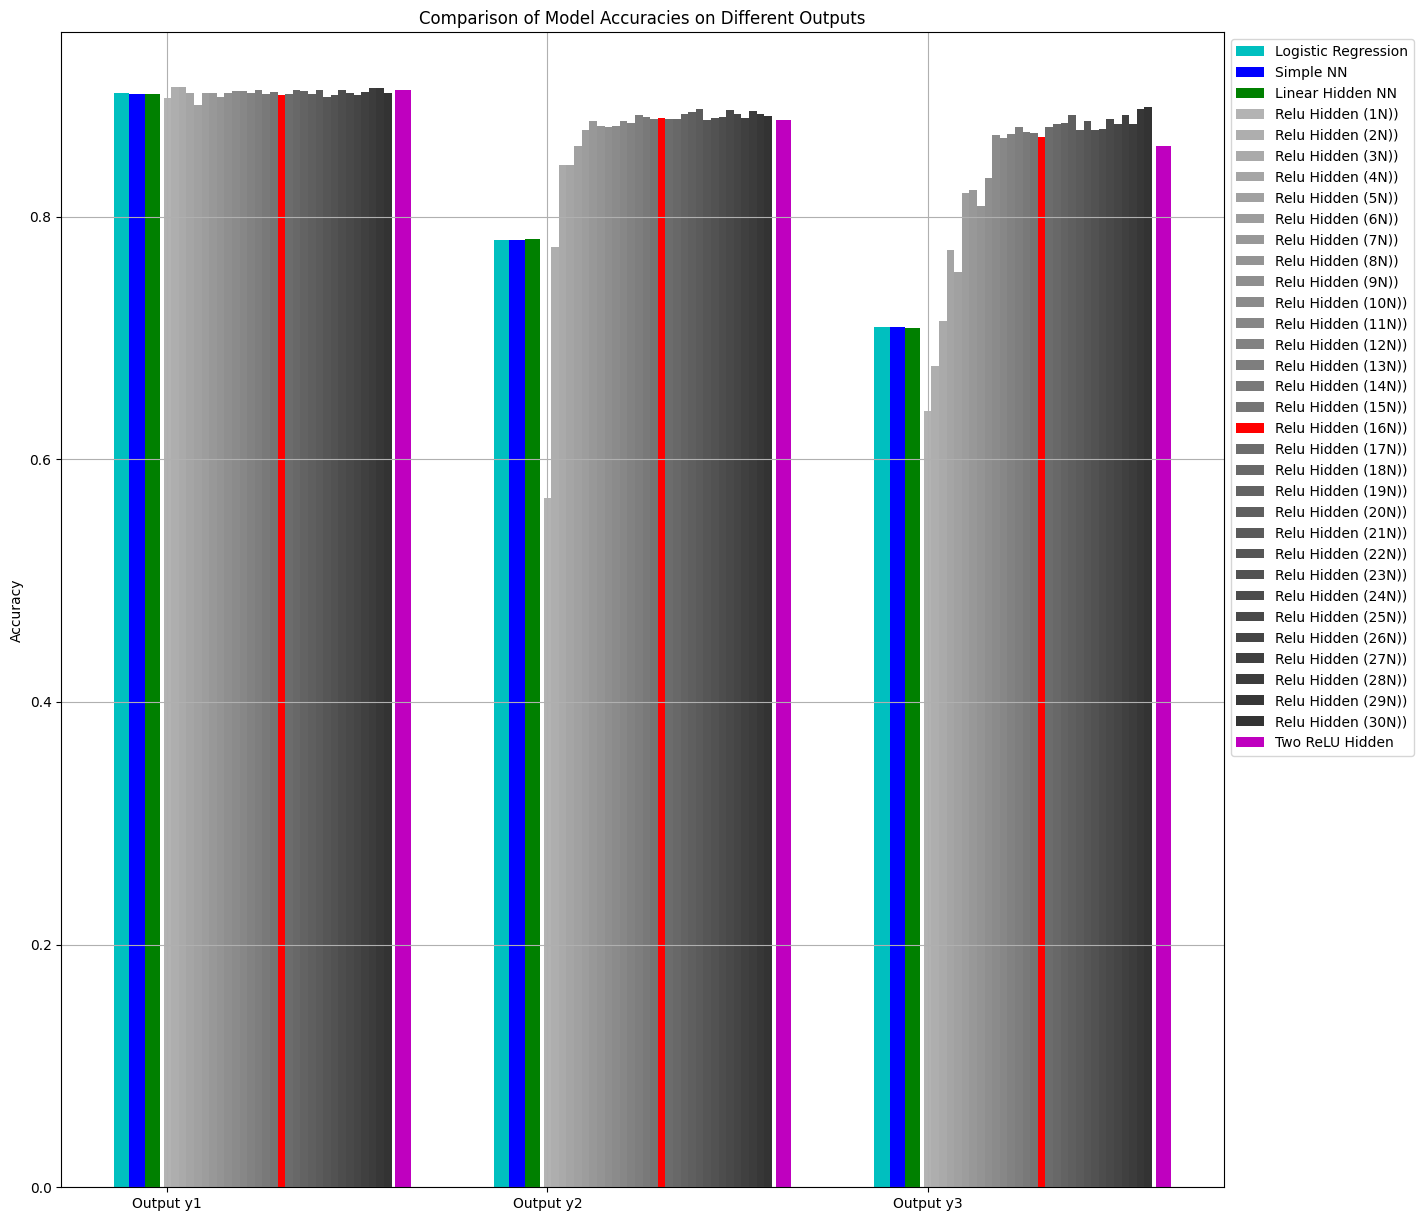

In [21]:
# Barcharts to Compare the Accuracies across Models:

labels = ['Output y1', 'Output y2', 'Output y3']
x = np.arange(len(labels))
width = 0.04

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.bar(x - 3*width, regression_accuracies, width, label='Logistic Regression', color='c')
rects2 = ax.bar(x - 2*width, simple_nn_accuracies, width, label='Simple NN', color='b')
rects3 = ax.bar(x - width, linear_nn_accuracies, width, label='Linear Hidden NN', color='g')

for i in range(len(relu_nn_accuracies)):
  if i == 15: color = 'r'
  else: color = colors[i]
  rects4 = ax.bar(x + i*width/2, relu_nn_accuracies[i], width/2, label=f'Relu Hidden ({i+1}N))', color=color)

# rects4 = ax.bar(x + 15*width/2, relu_nn_accuracies[15], width/2, label=f'Relu Hidden ({16}N))', color='r')

gap = (len(relu_hidden)+1)*width/2

rects5 = ax.bar(x + gap, two_nn_accuracies, width, label='Two ReLU Hidden', color='m')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies on Different Outputs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

In [22]:
# Compare weights and coefficients:

print("\n--- Comparison: Logistic Regression vs Simple Neural Network ---")
with torch.no_grad():
    for i in range(n_outputs):
        print(f"\nOutput y{i+1}:")
        # Extract sklearn logistic regression weights (coefficients and intercept)
        lr_weights = np.concatenate([lr_models[i].coef_[0], [lr_models[i].intercept_[0]]])

        # Extract PyTorch weights (weights and bias)
        nn_weights = np.concatenate([
            simple_nn.linear.weight.data[i].cpu().numpy(),
            [simple_nn.linear.bias.data[i].cpu().numpy()]
        ])

        print(f"Logistic Regression Coefficients: {lr_weights.round(4)}")
        print(f"Simple NN weights: {nn_weights.round(4)}")
        print(f"Mean absolute difference: {np.mean(np.abs(lr_weights - nn_weights)):.6f}")


--- Comparison: Logistic Regression vs Simple Neural Network ---

Output y1:
Logistic Regression Coefficients: [ 6.1746 -1.4161  0.3815 -0.0338  0.0152 -0.0186]
Simple NN weights: [ 5.7833 -1.3152  0.3595 -0.0308  0.0152 -0.019 ]
Mean absolute difference: 0.086268

Output y2:
Logistic Regression Coefficients: [-0.233   1.7507  0.9906  0.071   0.0163 -0.0107]
Simple NN weights: [-0.233   1.7507  0.9906  0.071   0.0163 -0.0107]
Mean absolute difference: 0.000000

Output y3:
Logistic Regression Coefficients: [ 0.3402 -0.0834  1.0905  0.3627  0.0783 -0.0058]
Simple NN weights: [ 0.3402 -0.0834  1.0905  0.3627  0.0783 -0.0058]
Mean absolute difference: 0.000000
